# **importing necessary library**

In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GlobalMaxPool1D
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.metrics import plot_confusion_matrix

# Loading **Datasets**

In [ ]:
! gdown --id 1Hc5eNA3e3jKelUgPREuRbPfuAIP62Y2Q

Downloading...
From: https://drive.google.com/uc?id=1Hc5eNA3e3jKelUgPREuRbPfuAIP62Y2Q
To: /content/Dataset1.json
100% 5.62M/5.62M [00:00<00:00, 49.7MB/s]


In [ ]:
! gdown --id 1YHnkgeQcFhM5yBuOUZYCGv23fmJUqLuM

Downloading...
From: https://drive.google.com/uc?id=1YHnkgeQcFhM5yBuOUZYCGv23fmJUqLuM
To: /content/Dataset2.json
100% 6.06M/6.06M [00:00<00:00, 53.0MB/s]


In [ ]:
#loading datasets
dataset_01 = pd.read_json("Dataset1.json", lines=True)
dataset_02 = pd.read_json("Dataset2.json", lines=True)

# combining two datasets
data =  pd.concat([dataset_01, dataset_02])
data.head(3)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1


# **Data cleaning**

In [ ]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    # emojis, symbols, transport, map symbols, flags removing from the text
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"   
                           u"\U0001F1E0-\U0001F1FF"   
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()

    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"can't", "can not", text)
   
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text) 

    text = re.sub(r"i'm", "i am", text)     
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"it's", "it is", text) 
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)  
   
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)

    return text

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data preprocessing**

In [ ]:
def CleanTokenize(df):
    head_lns = list()
    lns = df["headline"].values.tolist()

    for ln in lns:
        ln = clean_text(ln)
        tokens = word_tokenize(ln)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w for w in words if not w in stop_words]
        head_lns.append(words)
    return head_lns

head_lns = CleanTokenize(data)
head_lns[0:15]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages'],
 ['airline',
  'passengers',
  'tackle',
  'man',
  'rushes',
  'cockpit',
  'bomb',
  'threat'],
 ['facebook', 'reportedly', 'working', 'healthcare', 'features', 'apps'],
 ['north',
  'korea',
  'pr

# Most Frequent non-Sarcastic Word


(-0.5, 499.5, 249.5, -0.5)

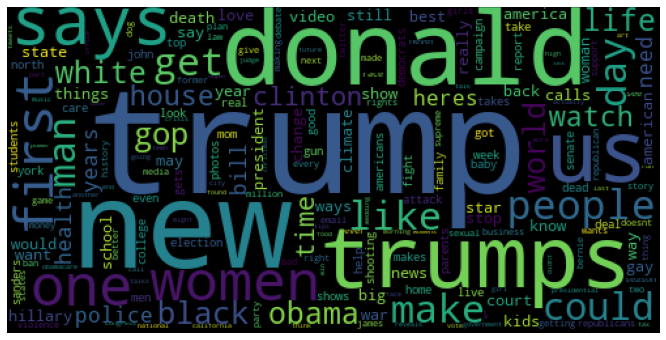

In [ ]:
pos_data = data.loc[data['is_sarcastic'] == 0]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 500, height = 250).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")

# Most Frequent Sarcastic Word

(-0.5, 499.5, 249.5, -0.5)

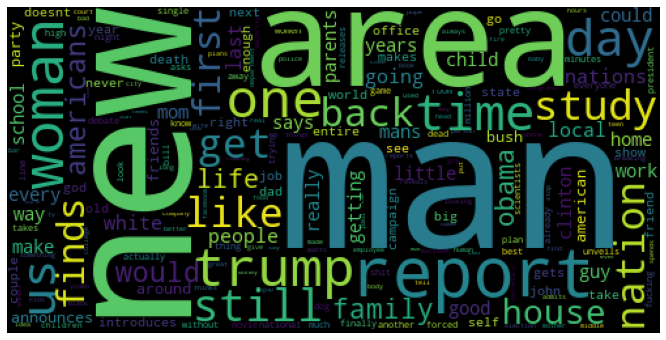

In [ ]:
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 500, height = 250).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")

# **Train Test Split**

In [ ]:
validation_split = 0.20
max_length = 25

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lns)
sequences = tokenizer_obj.texts_to_sequences(head_lns)
word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])
X_train = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


# **Total ammount of Datasets**

In [ ]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test: (11065, 25)
Shape of y_test: (11065,)


In [ ]:
! gdown --id 1AAJpGT0e9lDBPk-bAq13ZWlIeLQqq40J

Downloading...
From: https://drive.google.com/uc?id=1AAJpGT0e9lDBPk-bAq13ZWlIeLQqq40J
To: /content/glove.twitter.27B.100d.txt
100% 1.02G/1.02G [00:07<00:00, 139MB/s]


# **Load Glove Model**

In [ ]:
embeddings_index = {}
embedding_dim = 100
f = open(os.path.join('glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


# **Building a Embedding Layer**

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [ ]:
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

# **RNN model**

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix]))
model.add(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=3)
y_pred = model.predict([X_test], batch_size=1024, verbose=1)

print(model.summary())

Epoch 1/3
692/692 [==============================] - 62s 83ms/step - loss: 0.4515 - accuracy: 0.7827
Epoch 2/3
692/692 [==============================] - 57s 83ms/step - loss: 0.2571 - accuracy: 0.8949
Epoch 3/3
11/11 [==============================] - 1s 78ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         2865800   
                                                                 
 lstm (LSTM)                 (None, None, 50)          30200     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                      

## **Training**

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test), verbose=2)

Epoch 1/25
1384/1384 - 94s - loss: 0.0940 - accuracy: 0.9652 - val_loss: 0.1895 - val_accuracy: 0.9426 - 94s/epoch - 68ms/step
Epoch 2/25
1384/1384 - 93s - loss: 0.0500 - accuracy: 0.9825 - val_loss: 0.1912 - val_accuracy: 0.9518 - 93s/epoch - 67ms/step
Epoch 3/25
1384/1384 - 93s - loss: 0.0285 - accuracy: 0.9906 - val_loss: 0.2126 - val_accuracy: 0.9515 - 93s/epoch - 67ms/step
Epoch 4/25
1384/1384 - 97s - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.2365 - val_accuracy: 0.9554 - 97s/epoch - 70ms/step
Epoch 5/25
1384/1384 - 95s - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.2598 - val_accuracy: 0.9555 - 95s/epoch - 69ms/step
Epoch 6/25
1384/1384 - 94s - loss: 0.0110 - accuracy: 0.9960 - val_loss: 0.2861 - val_accuracy: 0.9556 - 94s/epoch - 68ms/step
Epoch 7/25
1384/1384 - 94s - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.3233 - val_accuracy: 0.9586 - 94s/epoch - 68ms/step
Epoch 8/25
1384/1384 - 95s - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.3219 - val_accuracy: 0.9577 - 95s/ep

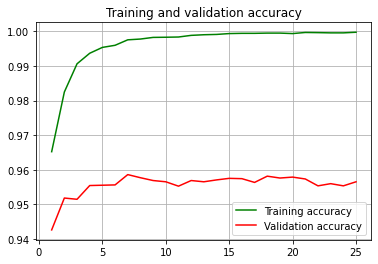

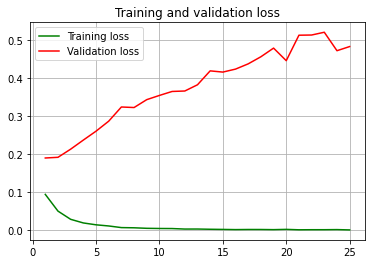

In [ ]:
# Plot results

plt.grid()
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()
plt.show()



Accuracy : 0.9764446955336326


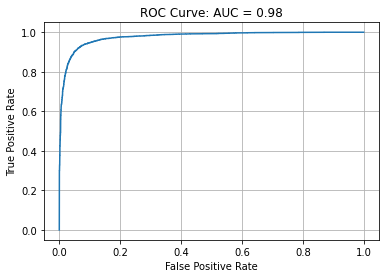

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

auc = np.trapz(tpr,fpr)
print('Accuracy :', auc)  
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: AUC = {0:0.2f}'.format(auc))
plt.plot(fpr,tpr)
plt.grid()
plt.show()

In [ ]:
#ACCURACY
y_pred1 = y_pred > 0.5
metrics.accuracy_score(y_pred1, y_test)


0.9292363307727067

In [ ]:
pred = y_pred > 0.5
f1_score(y_test, pred)

0.922727721306622

# **Result Analysis**

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


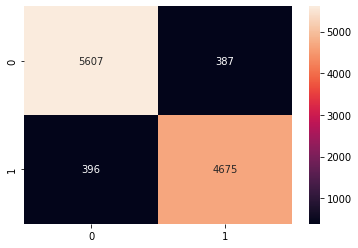

In [ ]:
#Confusion Matrix
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred1),annot=True,fmt="d"))

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: 
       return "It's a sarcasm!" 
    else:
       return "It's not a sarcasm."

In [ ]:
predict_sarcasm("You were looking so good that my eyes burnt. ")

"It's a sarcasm!"

In [ ]:
predict_sarcasm("She is very intelligent")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("You just broke my house window. Great job!!")

"It's a sarcasm!"

In [ ]:
predict_sarcasm("I love Human.")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")


"It's a sarcasm!"

In [ ]:
predict_sarcasm("I love the movie so much that I leave the theater during interval.")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("I am so hungry that I can eat an elephant.")

"It's not a sarcasm."

In [ ]:
predict_sarcasm("If you are depressed, stop being sad. ")

"It's a sarcasm!"